In [7]:
import os as os
import warnings

import cudaq
import matplotlib.pyplot as plt
import pandas as pd
from bigdatavqa.coreset import BFL2, D2_sampling
from bigdatavqa.Hamiltonians import get_K3_Hamiltonian
from bigdatavqa.k3meansclustering import (
    K3MeansClusteringKMeans,
    K3MeansClusteringMaxCut,
    K3MeansClusteringRandom,
    K3MeansClusteringVQA,
)
from bigdatavqa.optimizer import get_optimizer_for_QAOA, get_optimizer_for_VQE
from bigdatavqa.ansatz import get_ansatz_for_QAOA, get_ansatz_for_VQE

warnings.filterwarnings("ignore")

In [5]:
qubits = 10
number_of_qubits_representing_data_point = 2
coreset_size = int(qubits / number_of_qubits_representing_data_point)
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_experiment_runs = 5
number_of_corsets_to_evaluate = 15
number_of_centroid_evaluation = 20

In [9]:
raw_data = BFL2.create_dataset(1000)

coreset = BFL2(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    sampling_method=D2_sampling,
)


coreset_vectors, coreset_weights = coreset.get_best_coresets()

vector_columns = ["X", "Y"]
weights_column = "weights"

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df[weights_column] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,7.149804,0.069156,155.588294,A
1,-0.426790,0.129026,187.524917,B
2,1.294049,-0.546896,152.248236,C
3,0.510718,-1.780673,35.605036,D
4,-2.514749,2.047138,21.084559,E
5,0.501777,1.006609,45.659791,F
6,6.237342,2.646412,98.045064,G
7,6.356601,0.774965,80.823538,H
8,-0.248031,0.524120,108.979557,I
9,-1.981689,2.561941,24.073528,J


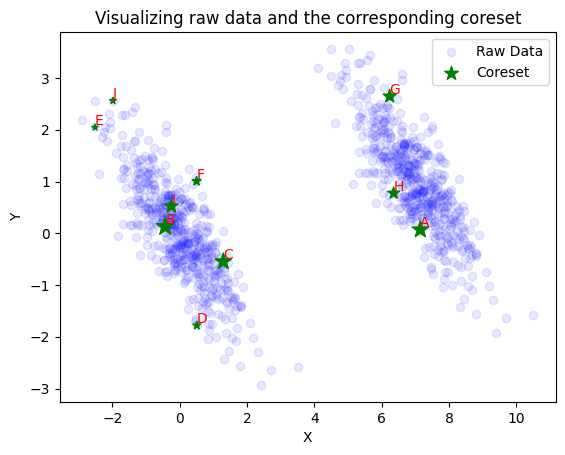

In [10]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color="blue", alpha=0.09, label="Raw Data")
plt.scatter(
    coreset_df.X,
    coreset_df.Y,
    s=coreset_df.weights,
    marker="*",
    color="green",
    label="Coreset",
)
for idx, row in coreset_df.iterrows():
    plt.annotate(row["Name"], xy=(row.X, row.Y + 0.05), color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Visualizing raw data and the corresponding coreset")
plt.show()

## VQE K3 clustering

In [11]:
optimizer = cudaq.optimizers.COBYLA()

k3meansVQE = K3MeansClusteringVQA(
    coreset_df = coreset_df,
    vector_columns=vector_columns,
    weight_columns=weights_column,
    qubits=qubits,
    create_circuit=get_VQE_circuit,
    circuit_depth=1,
    optimizer_function=get_optimizer_for_VQE,
    optimizer=optimizer,
    create_Hamiltonian=get_K3_Hamiltonian,
    number_of_qubits_representing_data=number_of_qubits_representing_data_point,
    normalize_vectors=True,
    max_iterations=max_iterations,
    max_shots=max_shots,
)



k3meansVQE.fit()


print(f"VQE cost value: {VQE_cost_value}")

NameError: name 'get_VQE_circuit' is not defined

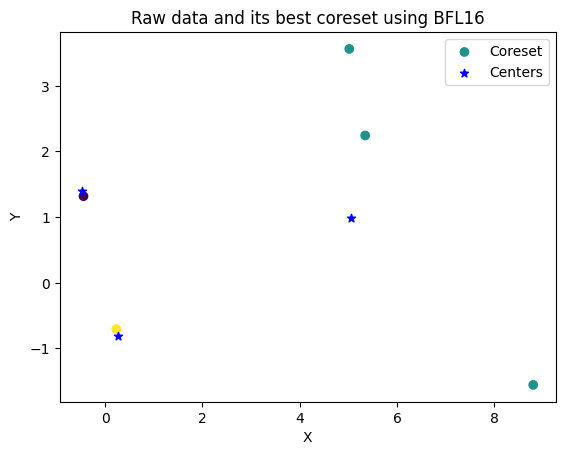

In [5]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## KMeans clustering

In [6]:
K3meansKMeans = K3MeansClusteringKMeans(normalize_vectors=False)

centers = K3meansKMeans.get_cluster_centers(
    coreset_df=raw_data_df, vector_columns=["X", "Y"], weight_columns="weights"
)

KMeans_cost, labels = K3meansKMeans.get_3means_cost(coreset_vectors, centers)

print(f"KMeans cost value: {KMeans_cost}")

KMeans cost value: 25.137210740615096


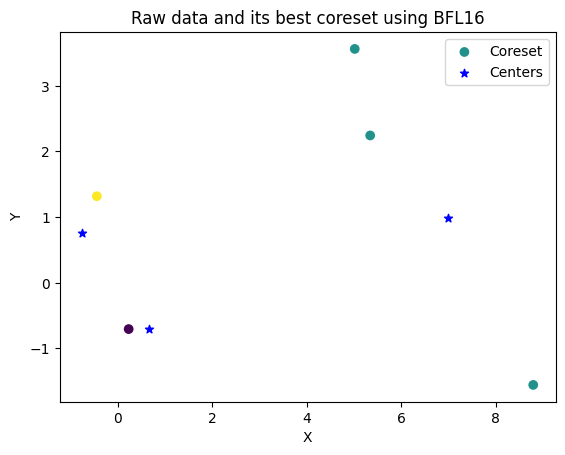

In [7]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## Random clustering

In [8]:
K3MeansRandom = K3MeansClusteringRandom(
    number_of_qubits_representing_data=number_of_qubits_representing_data_point
)
centers = K3MeansRandom.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)

random_cost, labels = K3MeansRandom.get_3means_cost(coreset_vectors, centers)


print(f"Random cost value: {random_cost}")

Random cost value: 60.50539719499687


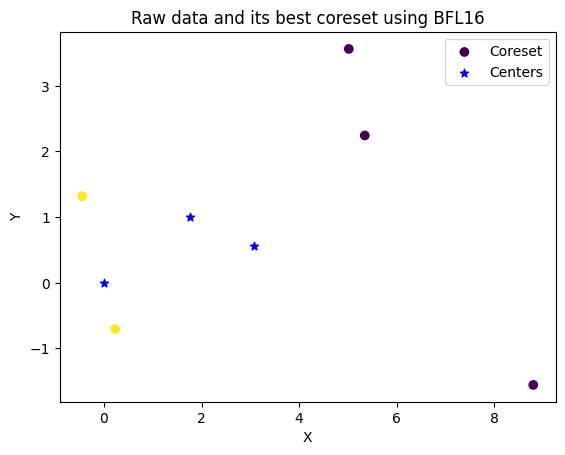

In [9]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## MaxCut

In [10]:
K3MeansMaxCut = K3MeansClusteringMaxCut()
centers = K3MeansMaxCut.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)

MaxCut_cost, labels = K3MeansMaxCut.get_3means_cost(coreset_vectors, centers)

print(f"MaxCut cost value: {MaxCut_cost}")

100%|██████████| 1022/1022 [00:02<00:00, 361.35it/s]

MaxCut cost value: 3.196169631792844


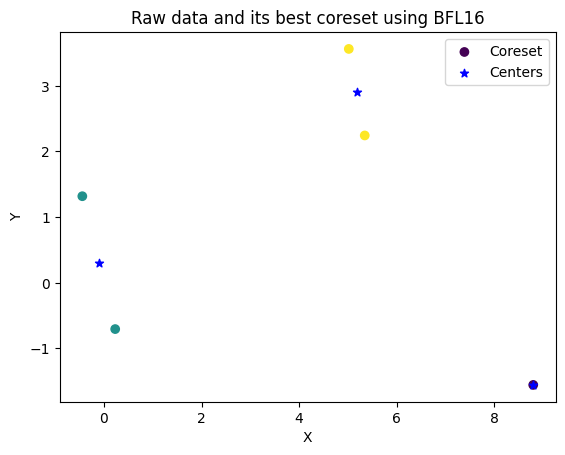

In [11]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

# Analyzing results

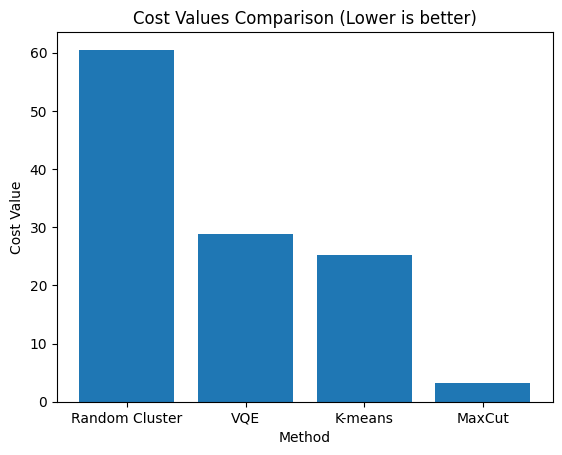

In [12]:
cost_values = [random_cost, VQE_cost_value, KMeans_cost, MaxCut_cost]


labels = ["Random Cluster", "VQE", "K-means", "MaxCut"]


plt.bar(labels, cost_values)


plt.xlabel("Method")
plt.ylabel("Cost Value")
plt.title("Cost Values Comparison (Lower is better)")


plt.show()